<h2> <center> Video classification </center> </h2>

The key factor here is to use the **rolling prediction average**. <br>
The algorithm is so : 

1. Loop over all frames in the video file
2. For each frame, pass the frame through the CNN
3. Obtain the predictions from the CNN
4. Maintain a list of the last K predictions
5. Compute the average of the last K predictions and choose the label with the largest corresponding probability
6. Label the frame and write the output frame to disk

<h3> 1. Data to use : </h3>

We will be using the Sports Classification Dataset. You can download it as follow : 

In [1]:
# !git clone https://github.com/anubhavmaity/Sports-Type-Classifier

Cloning into 'Sports-Type-Classifier'...
remote: Enumerating objects: 14521, done.
remote: Counting objects: 100% (14521/14521), done.
remote: Compressing objects: 100% (14512/14512), done.
remote: Total 14521 (delta 7), reused 14519 (delta 5), pack-reused 0
Receiving objects: 100% (14521/14521), 592.88 MiB | 5.05 MiB/s, done.
Resolving deltas: 100% (7/7), done.


Now let's get started with the code. 

<h3> 2. Different imports : </h3>

In [17]:
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.pooling import AveragePooling2D
from keras.applications import ResNet50
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import multi_gpu_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import os
import matplotlib 

# Ignore warnings:
import warnings
warnings.simplefilter('ignore')

<h3> 3. Coding : </h3>

In [3]:
data_path = 'Sports-Type-Classifier/data'

<h4> Data pre-processing </h4>

In [4]:
# initialize the set of labels from the spots activity dataset we are
# going to train our network on
LABELS = set(["weight_lifting", "tennis", "football", "basketball", "boxing", "table_tennis", "wwe", "volleyball"])
 
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images

print("[INFO] loading images...")

imagePaths = list(paths.list_images(data_path)) # To load just the images

data = []
labels = []
 
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
 
    # if the label of the current image is not part of of the labels
    # are interested in, then ignore the image
    if label not in LABELS:
        continue

    # load the image, convert it to RGB channel ordering, and resize
    # it to be a fixed 224x224 pixels, ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224)) # So it's already prepared to train the model

    # update the data and labels lists, respectively
    data.append(image) # list for all data ( images )
    labels.append(label) # list for all labels

print("[INFO] DONE.")

[INFO] loading images...
[INFO] DONE.


In [5]:
# convert the data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)
 
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print('One hot encoding of the labels :', labels.shape)
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
print('[INFO] Done splitting data.')

One hot encoding of the labels : (5339, 8)
[INFO] Done splitting data.


In [6]:
trainX.shape, testX.shape, trainY.shape, testY.shape

((4271, 224, 224, 3), (1068, 224, 224, 3), (4271, 8), (1068, 8))

We are set to go, dimensions seems to match. 

<h4> Data augmentation </h4>

In [7]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")


# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator(    
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
# IMAGE NORMALIZATION :
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

<h4> Model  </h4>

Transfert learning :

In [8]:
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
 
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(lb.classes_), activation="softmax")(headModel)
 
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
 
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
    layer.trainable = False

94658560/94653016 [==============================] - 32s 0us/step


Let's compile and train our model :

In [9]:
# Let's define some parametrs :
nb_epochs = 200

In [18]:
print("[INFO] compiling model...")
opt = SGD(lr=1e-4, momentum=0.9, decay=1e-4 / nb_epochs)

model = multi_gpu_model(model, gpus=2)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


Now, I'll add some useful callbacks :

In [14]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_acc', patience=50)
cb_checkpointer = ModelCheckpoint(filepath = 'video_classification.hdf5', monitor = 'val_acc', save_best_only = True, mode = 'auto')

In [19]:
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=32),
    steps_per_epoch=len(trainX) // 32,
    validation_data=valAug.flow(testX, testY),
    validation_steps=len(testX) // 32,
    epochs=nb_epochs,
    callbacks=[cb_early_stopper, cb_checkpointer])

[INFO] training head...
Epoch 1/200
133/133 [==============================] - 37s 277ms/step - loss: 0.8131 - acc: 0.7270 - val_loss: 0.8456 - val_acc: 0.7064
Epoch 2/200
133/133 [==============================] - 33s 245ms/step - loss: 0.8110 - acc: 0.7283 - val_loss: 0.8369 - val_acc: 0.7210
Epoch 3/200
133/133 [==============================] - 33s 247ms/step - loss: 0.7807 - acc: 0.7346 - val_loss: 0.8404 - val_acc: 0.7114
Epoch 4/200
133/133 [==============================] - 34s 254ms/step - loss: 0.7821 - acc: 0.7366 - val_loss: 0.8456 - val_acc: 0.7268
Epoch 5/200
133/133 [==============================] - 33s 251ms/step - loss: 0.7615 - acc: 0.7401 - val_loss: 0.7839 - val_acc: 0.7432
Epoch 6/200
133/133 [==============================] - 33s 246ms/step - loss: 0.7529 - acc: 0.7480 - val_loss: 0.8405 - val_acc: 0.7249
Epoch 7/200
133/133 [==============================] - 32s 243ms/step - loss: 0.7593 - acc: 0.7428 - val_loss: 0.8274 - val_acc: 0.7172
Epoch 8/200
133/133 [===

Epoch 61/200
133/133 [==============================] - 32s 243ms/step - loss: 0.5214 - acc: 0.8234 - val_loss: 0.7396 - val_acc: 0.7674
Epoch 62/200
133/133 [==============================] - 32s 243ms/step - loss: 0.5101 - acc: 0.8254 - val_loss: 0.7811 - val_acc: 0.7490
Epoch 63/200
133/133 [==============================] - 32s 240ms/step - loss: 0.5251 - acc: 0.8225 - val_loss: 0.7621 - val_acc: 0.7548
Epoch 64/200
133/133 [==============================] - 33s 246ms/step - loss: 0.5285 - acc: 0.8239 - val_loss: 0.7247 - val_acc: 0.7510
Epoch 65/200
133/133 [==============================] - 32s 240ms/step - loss: 0.5038 - acc: 0.8225 - val_loss: 0.7613 - val_acc: 0.7481
Epoch 66/200
133/133 [==============================] - 32s 242ms/step - loss: 0.5131 - acc: 0.8257 - val_loss: 0.7771 - val_acc: 0.7548
Epoch 67/200
133/133 [==============================] - 32s 241ms/step - loss: 0.5334 - acc: 0.8241 - val_loss: 0.7449 - val_acc: 0.7587
Epoch 68/200
133/133 [===================

133/133 [==============================] - 33s 249ms/step - loss: 0.4368 - acc: 0.8557 - val_loss: 0.7085 - val_acc: 0.7703
Epoch 121/200
133/133 [==============================] - 33s 250ms/step - loss: 0.4430 - acc: 0.8487 - val_loss: 0.8395 - val_acc: 0.7365
Epoch 122/200
133/133 [==============================] - 33s 246ms/step - loss: 0.4384 - acc: 0.8523 - val_loss: 0.7774 - val_acc: 0.7597
Epoch 123/200
133/133 [==============================] - 33s 248ms/step - loss: 0.4306 - acc: 0.8517 - val_loss: 0.7290 - val_acc: 0.7664
Epoch 124/200
133/133 [==============================] - 32s 242ms/step - loss: 0.4480 - acc: 0.8481 - val_loss: 0.7625 - val_acc: 0.7481
Epoch 125/200
133/133 [==============================] - 32s 241ms/step - loss: 0.4339 - acc: 0.8526 - val_loss: 0.7804 - val_acc: 0.7712
Epoch 126/200
133/133 [==============================] - 32s 243ms/step - loss: 0.4209 - acc: 0.8566 - val_loss: 0.7703 - val_acc: 0.7510
Epoch 127/200
133/133 [=========================

<h4> Loading the model </h4>

In [20]:
from keras.models import load_model
model = load_model('video_classification.hdf5')

<h4> Model evaluation </h4>

In [21]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=lb.classes_))

[INFO] evaluating network...
                precision    recall  f1-score   support

    basketball       0.70      0.88      0.78        98
        boxing       0.75      0.82      0.79       141
      football       0.94      0.92      0.93       157
  table_tennis       0.98      0.65      0.78       141
        tennis       0.82      0.90      0.86       143
    volleyball       0.73      0.89      0.81       141
weight_lifting       0.82      0.88      0.85       114
           wwe       0.86      0.59      0.70       133

     micro avg       0.82      0.82      0.82      1068
     macro avg       0.82      0.82      0.81      1068
  weighted avg       0.83      0.82      0.81      1068



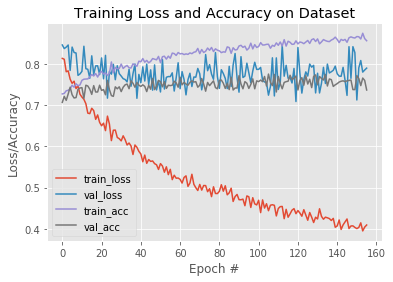

In [24]:
# plot the training loss and accuracy
N = 156
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

<h3> 4. Video classification with the rolling prediction averaging : </h3>

In [26]:
# initialize the image mean for mean subtraction along with the
# predictions queue : 
# We will be using deque from collections 
from collections import deque

mean = np.array([123.68, 116.779, 103.939], dtype="float32")
Q = deque(maxlen=150)

Queue size will be equal to 150.

In [27]:
video_name = 'videoplayback.mp4'

In [28]:
# initialize the video stream, pointer to output video file, and
# frame dimensions
vs = cv2.VideoCapture(video_name)
writer = None
(W, H) = (None, None)
 
# loop over frames from the video file stream
while True:
    # read the next frame from the file
    (grabbed, frame) = vs.read()

    # if the frame was not grabbed, then we have reached the end
    # of the stream
    if not grabbed:
        break

    # if the frame dimensions are empty, grab them
    if W is None or H is None:
        (H, W) = frame.shape[:2]
        
    # clone the output frame, then convert it from BGR to RGB
    # ordering, resize the frame to a fixed 224x224, and then
    # perform mean subtraction
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (224, 224)).astype("float32")
    frame -= mean
    
    # make predictions on the frame and then update the predictions
    # queue
    preds = model.predict(np.expand_dims(frame, axis=0))[0]
    Q.append(preds)

    # perform prediction averaging over the current history of
    # previous predictions
    results = np.array(Q).mean(axis=0)
    i = np.argmax(results)
    label = lb.classes_[i]
    
    # draw the activity on the output frame
    text = "Activity : {}".format(label)
    cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,
        1.25, (0, 255, 0), 5)

    # check if the video writer is None
    if writer is None:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter('saved_video', fourcc, 30,
            (W, H), True)

    # write the output frame to disk
    writer.write(output)

    # show the output image
    cv2.imshow("Output", output)
    key = cv2.waitKey(1) & 0xFF

    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()

[INFO] cleaning up...


As we see, even if the model image classification is really bad, we still have some accurate video classification by using the rolling prediction avereging. 